# Synopsis

Applying Syuzhet methods to *Dracula* using NRC, Bing, Syuzhet, and VADER.

# Configuration

In [1]:
pwd

'/sfs/qumulo/qhome/sk5be/DS5559/lab11'

In [2]:
pwd = '/sfs/qumulo/qhome/sk5be/DS5559/lab11'

# Developed in other notebook
lex_db = './lexicons.db'

# Developed in previous lab
text_db = '/sfs/qumulo/qhome/sk5be/DS5559/HarryPotter.db'
OHCO = ['genre', 'author', 'book_num', 'chap_num', 'para_num', 'sent_num']
BOOKS = OHCO[:3]
CHAPS = OHCO[:4]
PARAS = OHCO[:5]
SENTS = OHCO[:6]

novel = 'HarryPotter'

# emo = 'bing_sentiment'
emo = 'syu_sentiment'

# For KDE
kde_kernel = 'gaussian'
# kde_bandwidth = 100
kde_samples = 1000

# Libraries

In [3]:
import pandas as pd
import numpy as np
import scipy as sp
import sys
import scipy.fftpack as fftpack
from sklearn.neighbors import KernelDensity as KDE
from sklearn.preprocessing import scale

import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display, HTML

# Pragmas

In [4]:
%cd {pwd}
%matplotlib inline
sns.set()
plt.style.use('fivethirtyeight')

/sfs/qumulo/qhome/sk5be/DS5559/lab11


# Process

## Get Lexicons

In [5]:
with sqlite3.connect(lex_db) as db:
    combo = pd.read_sql('SELECT * FROM combo', db, index_col='term_str')

In [6]:
combo.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
term_str,,,,,,,,,,,,,,,
abandon,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.75,-1.0
abandoned,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,-0.50,NaN
abandoner,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.25,NaN
abandonment,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,-0.25,-1.0
abandons,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.00,NaN


### Get lexicon columns

In [7]:
# emo_cols = [col for col in combo.columns if 'nrc_' in col]
emo_cols = combo.columns

In [8]:
emo_cols

Index(['nrc_anger', 'nrc_anticipation', 'nrc_disgust', 'nrc_fear', 'nrc_joy',
       'nrc_negative', 'nrc_positive', 'nrc_sadness', 'nrc_surprise',
       'nrc_trust', 'bing_negative', 'bing_positive', 'bing_sentiment',
       'syu_sentiment', 'gi_sentiment'],
      dtype='object')

# Get Text

In [9]:
# with sqlite3.connect(text_db) as db:
#     tokens = pd.read_sql("SELECT * FROM token WHERE book = '{}' AND punc = 0".format(novel), db, index_col=OHCO)
#     vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

In [10]:
with sqlite3.connect(text_db) as db:
    tokens = pd.read_sql("SELECT * FROM token WHERE punc = 0", db)
    vocab = pd.read_sql("SELECT * FROM vocab", db, index_col='term_id')

### Merge sentiment lexicon with vocab

In [11]:
tokens = tokens.join(combo, on='term_str', how='left')
tokens[emo_cols] = tokens[emo_cols].fillna(0)
tokens.head()

,index,book_num,chap_num,para_num,sent_num,token_num,pos,token_str,punc,num,...,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0,0,0,0,0,0,NN,CHAPTER,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,1,0,0,0,0,1,CD,ONE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,2,0,0,1,0,0,DT,THE,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,3,0,0,1,0,1,NNP,BOY,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0
4,4,0,0,1,0,2,NNP,WHO,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


In [26]:
tokens.to_csv("tokens_sentiment_ungroup.csv")

In [27]:
tokens = tokens.set_index((['genre', 'author', 'book_num', 'chap_num', 'para_num', 'sent_num']), drop=True)
tokens.head()
tokens.to_csv("tokens_sentiment_group.csv")

In [26]:
tokens.head()
tokens.to_csv("byword.csv")

In [16]:
tokens[emo].sample(10)

genre    author       book_num  chap_num  para_num  sent_num
Fantasy  J.K.Rowling  2         15        58        0           0.8
                      3         4         1         141         NaN
                      2         10        97        1           NaN
                      4         13        0         192         NaN
                      0         4         204       4           NaN
                      6         14        3         35          NaN
                                21        10        11          NaN
                      3         26        7         82          NaN
                      5         9         0         158        -1.0
                      4         11        0         506         NaN
Name: syu_sentiment, dtype: float64

## Sentiment by OHCO

In [13]:
FIG = dict(figsize=(25, 5), legend=True, fontsize=14, rot=45)

### By Book

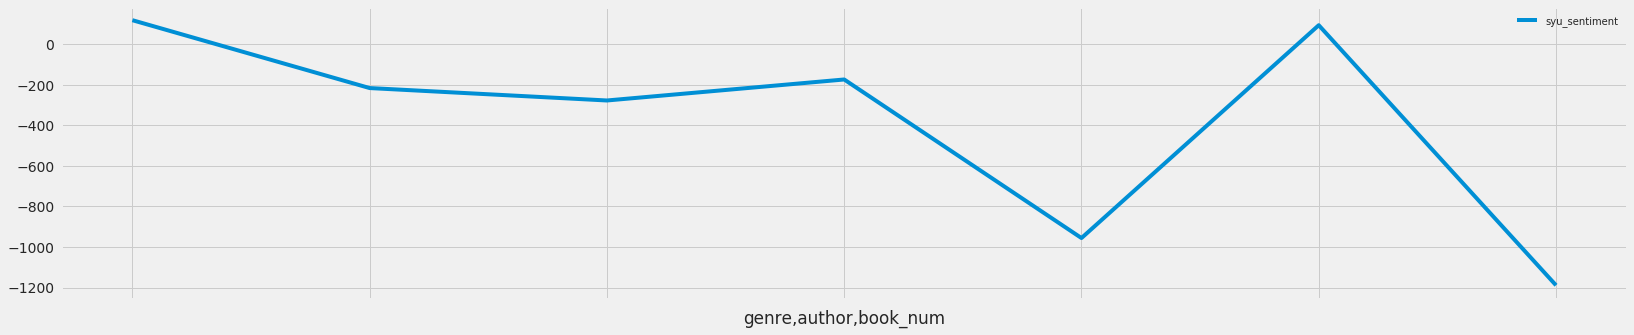

In [15]:
tokens.groupby(BOOKS)[emo].sum().plot(**FIG)

In [18]:
bybook = tokens.groupby(BOOKS)[emo_cols].sum()
bybook.to_csv("bybook.csv")

### By Chapter

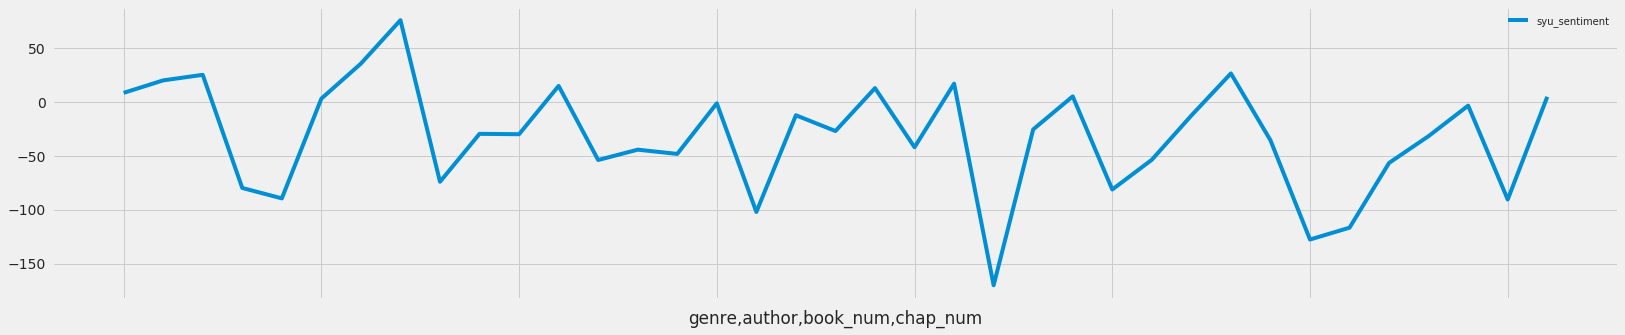

In [14]:
tokens.query("book_num == 6").groupby(CHAPS)[emo].sum().plot(**FIG)

In [20]:
bychaps = tokens.groupby(CHAPS)[emo_cols].sum()
bychaps.to_csv("bychaps.csv")

### By Paragraph

In [22]:
by_para = tokens.groupby(PARAS)[emo_cols].sum()
by_para.to_csv("bypara.csv")

In [27]:
by_para

nrc_anger  nrc_anticipation  \
genre   author      book_num chap_num para_num                                
Fantasy J.K.Rowling 0        0        0               0.0               0.0   
                                      1               0.0               0.0   
                                      2               0.0               3.0   
                                      3               0.0               0.0   
                                      4               2.0               3.0   
                                      5               1.0               1.0   
                                      6               0.0               0.0   
                                      7               0.0               2.0   
                                      8               0.0               0.0   
                                      9               1.0               2.0   
                                      10              0.0               2.0   
                                      11              1.0               0.0   
                                      12              1.0               0.0   
                                      13              1.0               0.0   
                                      14              5.0               2.0   
                                      15              0.0               0.0   
                                      16              2.0               4.0   
                                      17              0.0               0.0   
                                      18              0.0               1.0   
                                      19              0.0               1.0   
                                      20              0.0               0.0   
                                      21              0.0               0.0   
                                      22              0.0               3.0   
                                      23              1.0               1.0   
                                      24              1.0               1.0   
                                      25              0.0               1.0   
                                      26              1.0               0.0   
                                      27              0.0               0.0   
                                      28              1.0               0.0   
                                      29              0.0               0.0   
...                                                   ...               ...   
                    6        34       2              22.0               3.0   
                                      3              18.0              10.0   
                                      4              18.0               5.0   
                                      5              22.0              11.0   
                                      6               1.0               1.0   
                                      7              24.0              13.0   
                                      8              24.0              12.0   
                                      9              24.0              10.0   
                                      10             16.0               7.0   
                                      11              1.0               1.0   
                             35       0              18.0               9.0   
                                      1              19.0              18.0   
                                      2              27.0              12.0   
                                      3              40.0              10.0   
                                      4              15.0              10.0   
                                      5              38.0              11.0   
                                      6              30.0               3.0   
                                      7              26.0              10.0   
                   

In [59]:
max_x = by_para.shape[0]
xticks = list(range(0, max_x, 100))
xticks.append(max_x - 1)

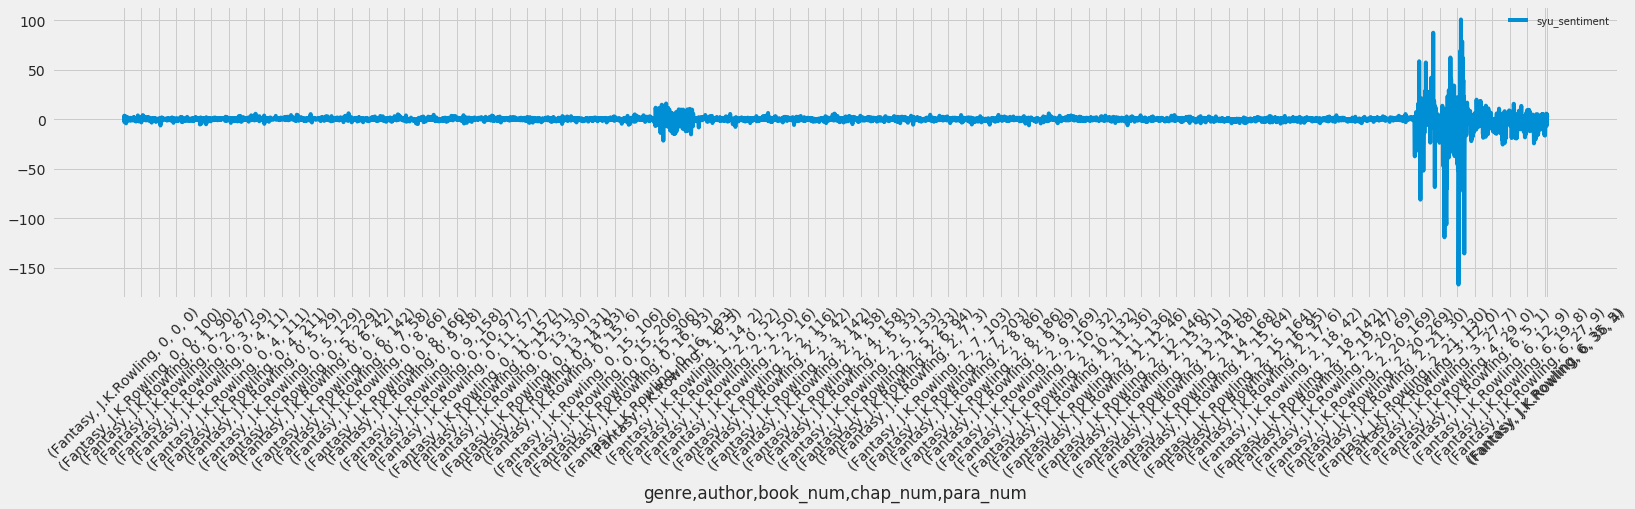

In [60]:
by_para[emo].plot(**FIG, xticks=xticks)

### By Sentence

In [24]:
by_sent = tokens.groupby(SENTS)[emo_cols].sum()
by_sent.to_csv("bysent.csv")

In [62]:
max_x = by_sent.shape[0]
xticks = list(range(0, max_x, 250))
xticks.append(max_x - 1)

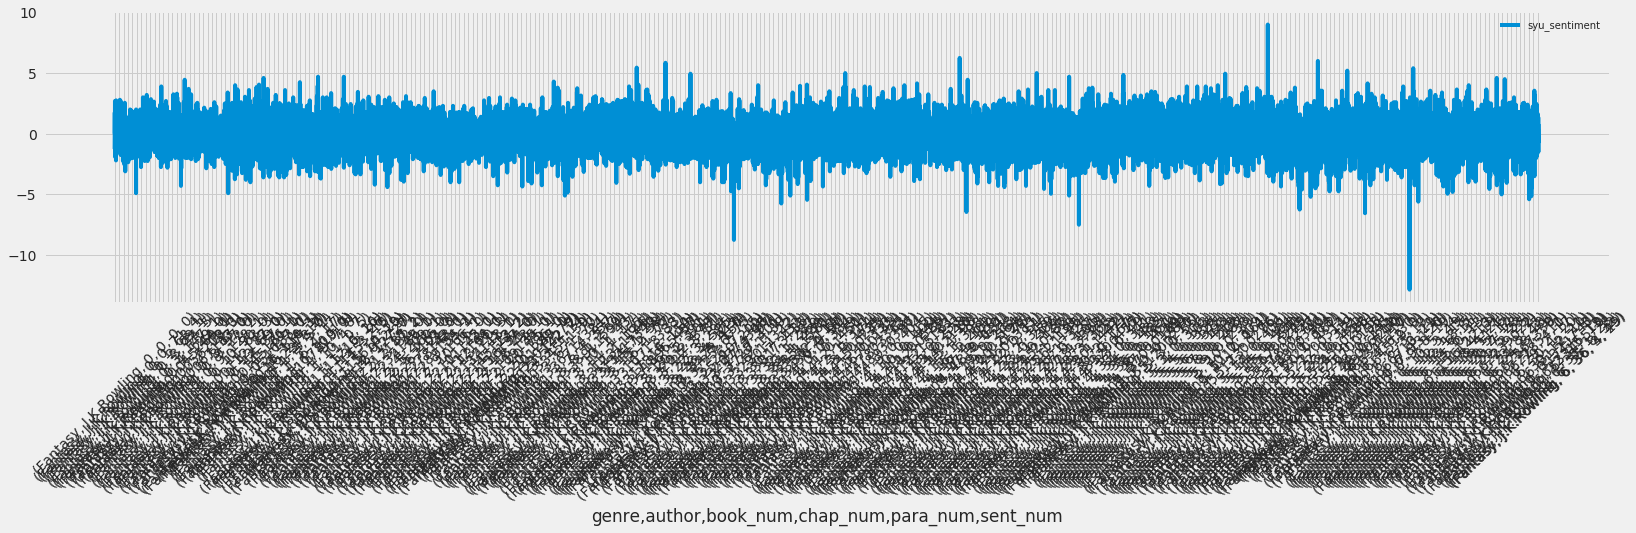

In [63]:
by_sent[emo].plot(**FIG, xticks=xticks)

### Add text to do spot checks

In [64]:
tokens['html'] =  tokens.apply(lambda x: 
                               "<span class='sent{}'>{}</span>".format(int(np.sign(x[emo])), x.token_str), 1)

In [65]:
tokens['html'].head()

genre    author       book_num  chap_num  para_num  sent_num
Fantasy  J.K.Rowling  0         0         0         0           <span class='sent0'>CHAPTER</span>
                                                    0               <span class='sent0'>ONE</span>
                                          1         0               <span class='sent0'>THE</span>
                                                    0               <span class='sent1'>BOY</span>
                                                    0               <span class='sent0'>WHO</span>
Name: html, dtype: object

In [66]:
by_sent['sent_str'] = tokens.groupby(SENTS).term_str.apply(lambda x: x.str.cat(sep=' '))
by_sent['html_str'] = tokens.groupby(SENTS).html.apply(lambda x: x.str.cat(sep=' '))

In [67]:
by_sent[['sent_str', 'html_str']].head()

sent_str  \
genre   author      book_num chap_num para_num sent_num                                                      
Fantasy J.K.Rowling 0        0        0        0                                               chapter one   
                                      1        0                                         the boy who lived   
                                      2        0         mr and mrs dursley of number four privet drive...   
                                               1         they were the last people you 'd expect to be ...   
                                      3        0         mr dursley was the director of a firm called g...   

                                                                                                  html_str  
genre   author      book_num chap_num para_num sent_num                                                     
Fantasy J.K.Rowling 0        0        0        0         <span class='sent0'>CHAPTER</span> <span class...  
                                      1        0         <span class='sent0'>THE</span> <span class='se...  
                                      2        0         <span class='sent0'>Mr.</span> <span class='se...  
                                               1         <span class='sent0'>They</span> <span class='s...  
                                      3        0         <span class='sent0'>Mr.</span> <span class='se...

### Histogram

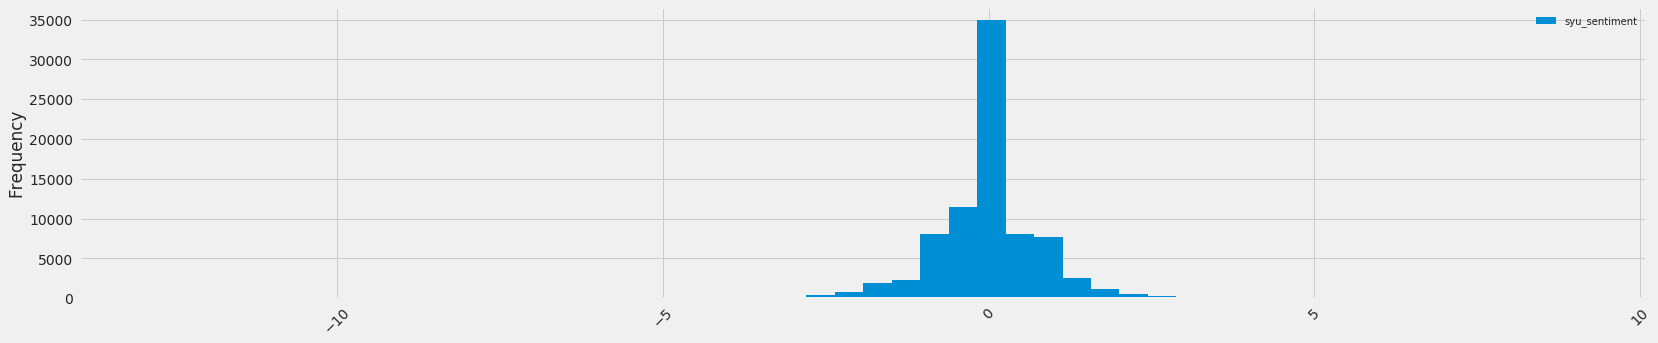

In [68]:
by_sent[emo].plot.hist(**FIG, bins=50)

### Look at a sample of sentences

In [69]:
rows = []
for idx in by_sent.sample(10).index:
    
    valence = round(by_sent.loc[idx, emo], 4)     
    t = 0
    if valence > t: color = '#ccffcc'
    elif valence < t: color = '#ffcccc'
    else: color = '#f2f2f2'
    z=0
    rows.append("""<tr style="background-color:{0};padding:.5rem 1rem;font-size:110%;">
    <td>{1}</td><td>{3}</td><td width="400" style="text-align:left;">{2}</td>
    </tr>""".format(color, valence, by_sent.loc[idx, 'html_str'], idx))
    
display(HTML('<style>#sample1 td{font-size:120%;vertical-align:top;} .sent-1{color:red;font-weight:bold;} .sent1{color:green;font-weight:bold;}</style>'))
display(HTML('<table id="sample1"><tr><th>Sentiment</th><th>ID</th><th width="600">Sentence</th></tr>'+''.join(rows)+'</table>'))

Sentiment,ID,Sentence
-0.25,"('Fantasy', 'J.K.Rowling', 2, 12, 149, 0)",There was a stunned silence both inside and outside the common room
-1.6,"('Fantasy', 'J.K.Rowling', 3, 27, 1, 23)",Her clothes were ragged and unwashed
0.5,"('Fantasy', 'J.K.Rowling', 0, 10, 47, 0)",And women Wood agreed
0.0,"('Fantasy', 'J.K.Rowling', 4, 24, 2, 196)",so
0.8,"('Fantasy', 'J.K.Rowling', 3, 18, 6, 187)",Men were shouting up ahead
1.05,"('Fantasy', 'J.K.Rowling', 3, 13, 1, 58)",Apparently Moody 's magical eye could see through solid wood as well as out of the back of his head
0.0,"('Fantasy', 'J.K.Rowling', 5, 4, 0, 358)",Neither Ron nor Hermione spoke
-0.45,"('Fantasy', 'J.K.Rowling', 2, 5, 81, 2)",Everyone had got to their feet and slowly they crowded around Harry and Ron 's table pressing close to Professor Trelawney 's chair to get a
-0.75,"('Fantasy', 'J.K.Rowling', 4, 13, 0, 610)",'I doubt it said Sirius
-0.6,"('Fantasy', 'J.K.Rowling', 5, 1, 0, 259)",And through all this we are supposed to believe Dumbledore has never suspected you


### Plot with Xticks

In [70]:
xticks = [0]
xticks += by_sent[emo].reset_index().sort_values(emo).head(7).index.values.tolist()
xticks += by_sent[emo].reset_index().sort_values(emo).tail(7).index.values.tolist()
xticks += [by_sent.shape[0] - 1]

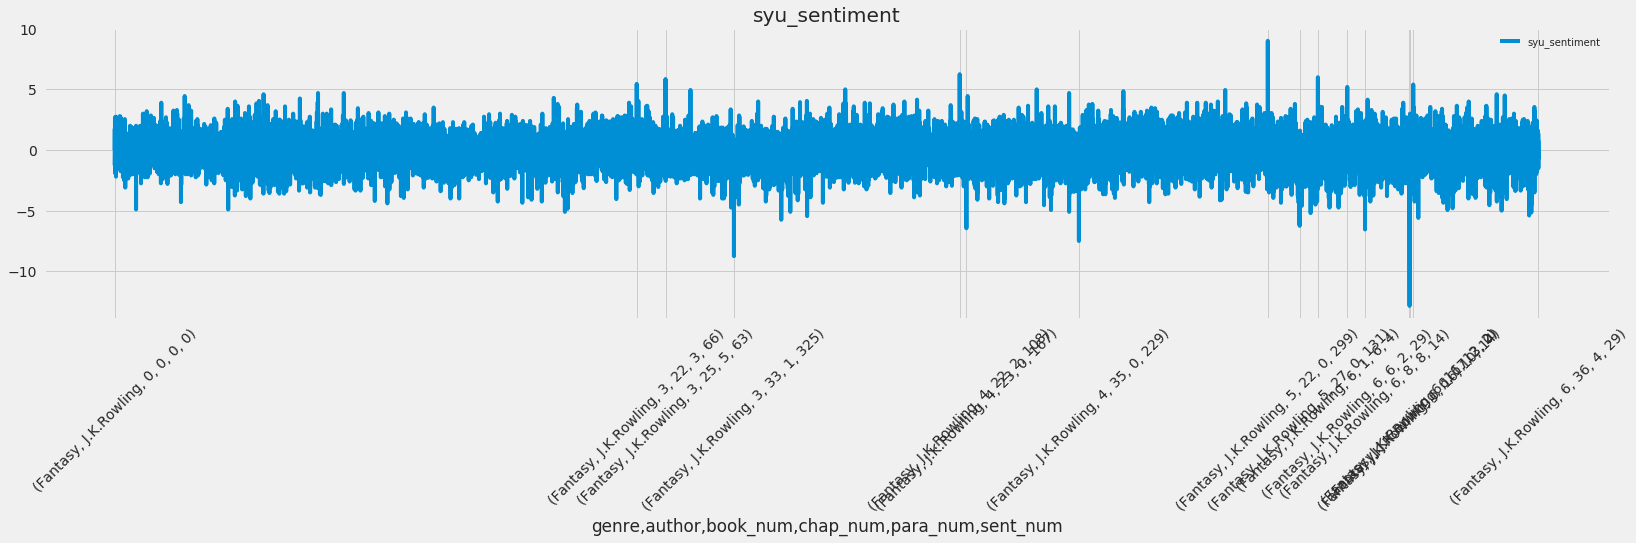

In [71]:
by_sent[emo].plot(**FIG, xticks=xticks, title=emo)

In [72]:
by_sent.iloc[xticks][emo].sort_index().to_frame()

syu_sentiment
genre   author      book_num chap_num para_num sent_num               
Fantasy J.K.Rowling 0        0        0        0                  0.00
                    3        22       3        66                 5.45
                             25       5        63                 5.85
                             33       1        325               -8.75
                    4        22       2        108                6.25
                             23       0        167               -6.45
                             35       0        229               -7.50
                    5        22       0        299                9.00
                             27       0        131               -6.25
                    6        1        6        4                  6.00
                             6        2        29                 5.20
                             8        8        14                -6.55
                             16       10       14                -6.30
                                      12       2                -12.85
                             17       3        0                  5.40
                             36       4        29                 0.80

### Inspect Positives

In [73]:
by_sent.sort_values(emo, ascending=False)[[emo,'sent_str']].head(20)

syu_sentiment  \
genre   author      book_num chap_num para_num sent_num                  
Fantasy J.K.Rowling 5        22       0        299                9.00   
                    4        22       2        108                6.25   
                    6        1        6        4                  6.00   
                    3        25       5        63                 5.85   
                             22       3        66                 5.45   
                    6        17       3        0                  5.40   
                             6        2        29                 5.20   
                    4        10       0        192                5.00   
                             30       0        7                  5.00   
                    3        27       7        184                4.95   
                    5        17       0        96                 4.95   
                             3        0        366                4.85   
                    2        3        15       2                  4.70   
                    1        16       4        19                 4.70   
                    4        34       0        174                4.70   
                    6        30       9        34                 4.60   
                    1        6        7        15                 4.60   
                    5        3        0        367                4.50   
                    6        31       8        5                  4.50   
                    0        10       64       0                  4.45   

                                                                                                  sent_str  
genre   author      book_num chap_num para_num sent_num                                                     
Fantasy J.K.Rowling 5        22       0        299       lord voldemort liked to collect trophies and h...  
                    4        22       2        108       the reception area looked pleasantly festive t...  
                    6        1        6        4         he not only won every prize of note that the s...  
                    3        25       5        63        people kept wishing him luck for the next morn...  
                             22       3        66        dobby knew sir must be a great wizard for he i...  
                    6        17       3        0         now approaching his eighteenth birthday dumble...  
                             6        2        29        the other packages contained an enchanted razo...  
                    4        10       0        192       we are very pleased to welcome back professor ...  
                             30       0        7         and i had about a second to decide which way t...  
                    3        27       7        184       yes my son has recently gained twelve owls mos...  
                    5        17       0        96        'just like his mother she had the same intuiti...  
                             3        0        366       he used to handpick favorites at hogwarts some...  
                    2        3        15       2         most important of all he had to buy his new sc...  
                    1        16       4        19        well said riddle smiling pleasantly how is it ...  
                    4        34       0        174       the hand released him at once they were at the...  
                    6        30       9        34        but it was well worth trying to get the job th...  
                    1        6        7        15        look at neville longbottom he s pure blood and...  
                    5        3        0        367       horace formed a kind of club of his favorites ...  
                    6        31       8        5         that 's right said luna encouragingly as if th...  
                    0        10       64       0         and she 's really belting along up there a nea...

### Inspect Negatives

In [74]:
by_sent.sort_values(emo, ascending=True)[[emo,'sent_str']].head(20)

syu_sentiment  \
genre   author      book_num chap_num para_num sent_num                  
Fantasy J.K.Rowling 6        16       12       2                -12.85   
                    3        33       1        325               -8.75   
                    4        35       0        229               -7.50   
                    6        8        8        14                -6.55   
                    4        23       0        167               -6.45   
                    6        16       10       14                -6.30   
                    5        27       0        131               -6.25   
                                               117               -6.10   
                    4        2        1        7                 -5.75   
                    6        18       4        15                -5.60   
                    4        5        0        236               -5.45   
                    6        35       2        5                 -5.40   
                             16       10       9                 -5.30   
                                      12       3                 -5.30   
                    5        29       0        113               -5.20   
                    6        35       5        18                -5.15   
                    4        34       0        173               -5.10   
                             3        0        141               -5.10   
                    3        13       1        7                 -5.10   
                    6        16       9        24                -5.10   

                                                                                                  sent_str  
genre   author      book_num chap_num para_num sent_num                                                     
Fantasy J.K.Rowling 6        16       12       2         glass cut his cheek as pulling hermione with h...  
                    3        33       1        325       harry yelled he did n't think he could have he...  
                    4        35       0        229       harry could not see why the hall was quite emp...  
                    6        8        8        14        he barely made it bolting the door behind him ...  
                    4        23       0        167       he had a bad feeling about this parting he did...  
                    6        16       10       14        everything was chaos it smashed shelves from t...  
                    5        27       0        131       kill me like you killed him you coward do n't ...  
                                               117       pushing himself to his feet again he staggered...  
                    4        2        1        7         harry was alternately filled with restless ene...  
                    6        18       4        15        thrashing suffocating he scrabbled at the stra...  
                    4        5        0        236       smells like a drain and a criminal to boot but...  
                    6        35       2        5         the two giants crashed along behind the death ...  
                             16       10       9         frozen air filled the room as harry ducked to ...  
                                      12       3         but if he had no body why did his head hurt so...  
                    5        29       0        113       they alone of all the da had responded to herm...  
                    6        35       5        18        they were hacking and stabbing at the ankles a...  
                    4        34       0        173       a death eater lunged forwards through the clou...  
                             3        0        141       every bitter and resentful thought harry had h...  
                    3        13       1        7         snape had disliked all of their previous dark ...  
                    6        16       9        24        and in the instant that he looked away his eye...

## Apply Transforms

### Adapt Jockers' original FFT function 

Fast Fourier Transform. See https://rdrr.io/cran/syuzhet/man/get_transformed_values.html

In [75]:
def get_transformed_values(raw_values, low_pass_size = 2, x_reverse_len = 100,  padding_factor = 2, scale_values = False, scale_range = False):

    if low_pass_size > len(raw_values):
        sys.exit("low_pass_size must be less than or equal to the length of raw_values input vector")

    raw_values_len = len(raw_values)
    padding_len = raw_values_len * padding_factor

    # Add padding, then fft
    values_fft = fftpack.fft(raw_values, padding_len)
    low_pass_size = low_pass_size * (1 + padding_factor)
    keepers = values_fft[:low_pass_size]

    # Preserve frequency domain structure
    modified_spectrum = list(keepers) \
        + list(np.zeros((x_reverse_len * (1+padding_factor)) - (2*low_pass_size) + 1)) \
        + list(reversed(np.conj(keepers[1:(len(keepers))])))
    
    
    # Strip padding
    inverse_values = fftpack.ifft(modified_spectrum)
    inverse_values = inverse_values[:x_reverse_len]

#     transformed_values = np.real(tuple(inverse_values))
    transformed_values = np.real(inverse_values)
    return transformed_values

In [76]:
FFTCFG = dict(
    low_pass_size = 3,
    x_reverse_len = 100,
    padding_factor = 2
)
X = get_transformed_values(by_sent[emo].values, **FFTCFG)

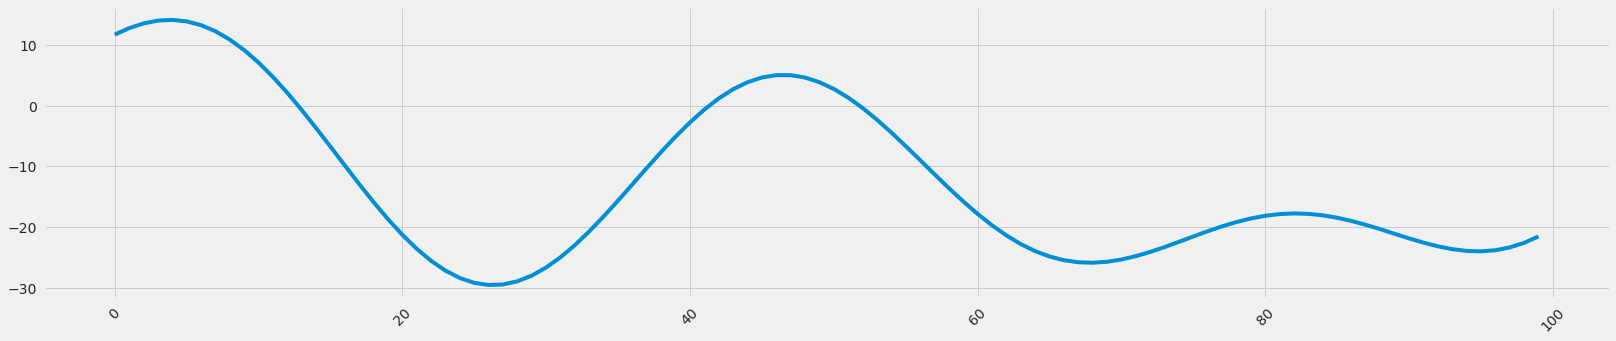

In [77]:
FIG['legend'] = False
pd.Series(X).plot(**FIG)

### Adapt Jockers' revised DCT function

Discrete Cosine Transform. A DCT is a Fourier-related transform similar to the discrete Fourier transform (DFT), but using only real numbers. 

In [78]:
def get_dct_transform(raw_values, low_pass_size = 5, x_reverse_len = 100):
    if low_pass_size > len(raw_values):
        raise ValueError("low_pass_size must be less than or equal to the length of raw_values input vector")
    values_dct = fftpack.dct(raw_values, type = 2)
    keepers = values_dct[:low_pass_size]
    padded_keepers = list(keepers) + list(np.zeros(x_reverse_len - low_pass_size))
    dct_out = fftpack.idct(padded_keepers)
    return(dct_out)

In [79]:
FFTCFG1 = dict(
    low_pass_size = 5,
    x_reverse_len = 100
)
X1 = get_dct_transform(by_sent[emo].values, **FFTCFG1)

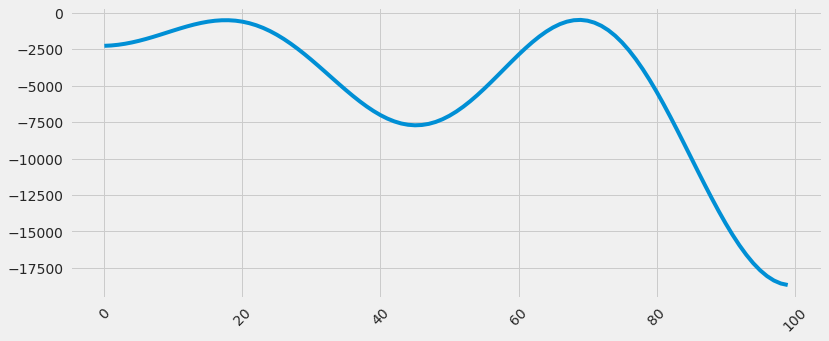

In [80]:
FIG['figsize'] = (12,5)
pd.Series(X1).plot(**FIG)

### Using Rolling
**Window types**: 
boxcar
triang
blackman
hamming
bartlett
parzen
bohman
blackmanharris
nuttall
barthann
kaiser (needs beta)
gaussian (needs std)
general_gaussian (needs power, width)
slepian (needs width).

In [81]:
# Config for sentences
CFG1 = dict(
    win_type='blackman',
    window=5000,
    center=True
)

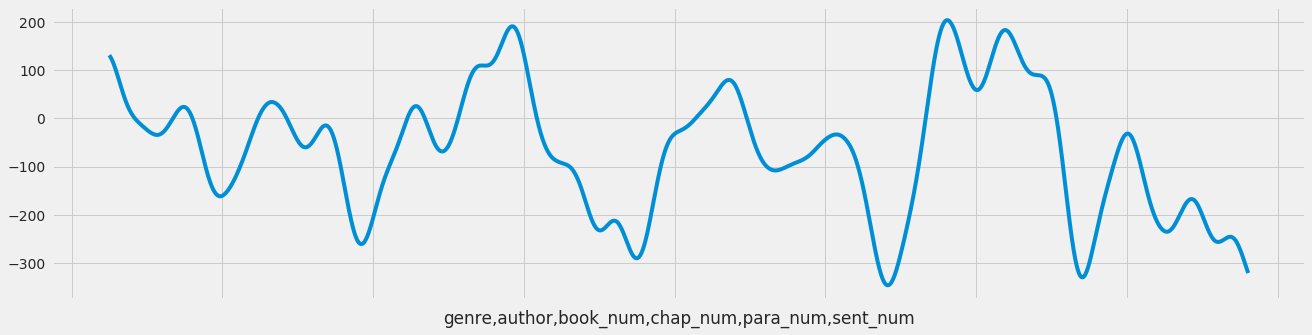

In [82]:
FIG['figsize'] = (20,5)
by_sent[emo].fillna(0).rolling(**CFG1).sum().plot(**FIG)

In [83]:
# Config for tokens
CFG2 = dict(
    win_type='blackman',
    window= int(tokens.shape[0]/ 3),
    center=True
)
CFG2['window']

374100

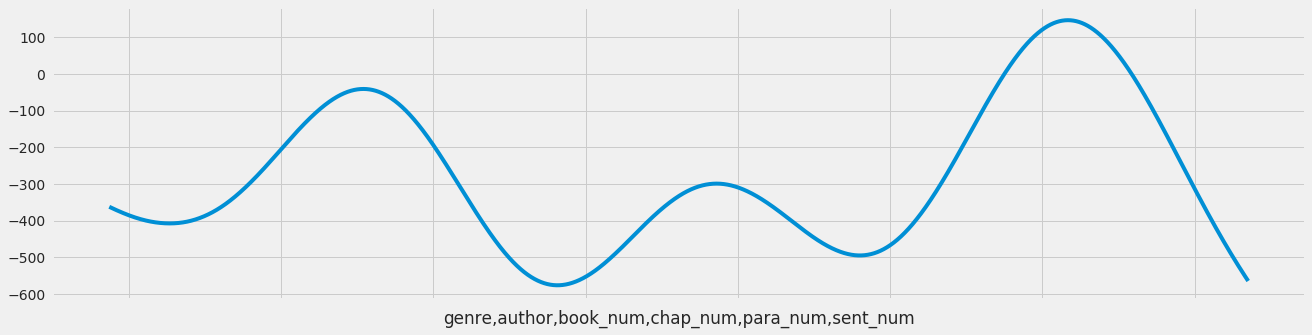

In [84]:
tokens[emo].fillna(0).rolling(**CFG2).sum().plot(**FIG)

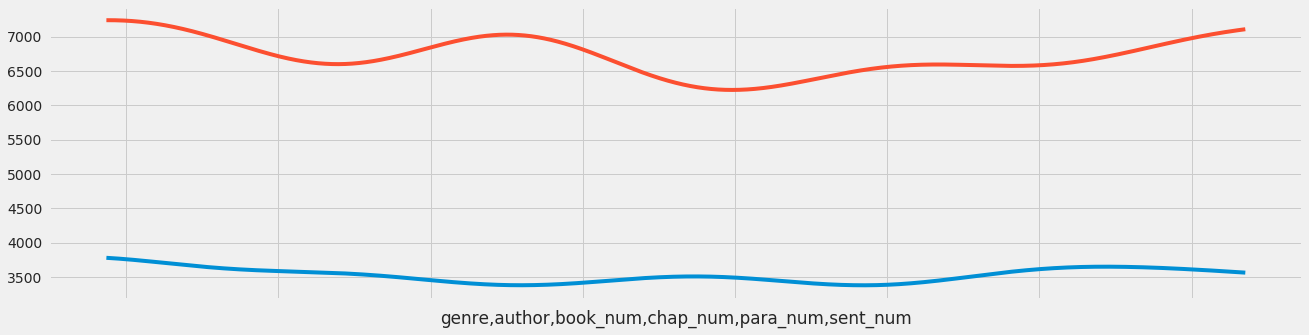

In [85]:
tokens[['nrc_positive','nrc_negative']].rolling(**CFG2).sum().plot(**FIG)

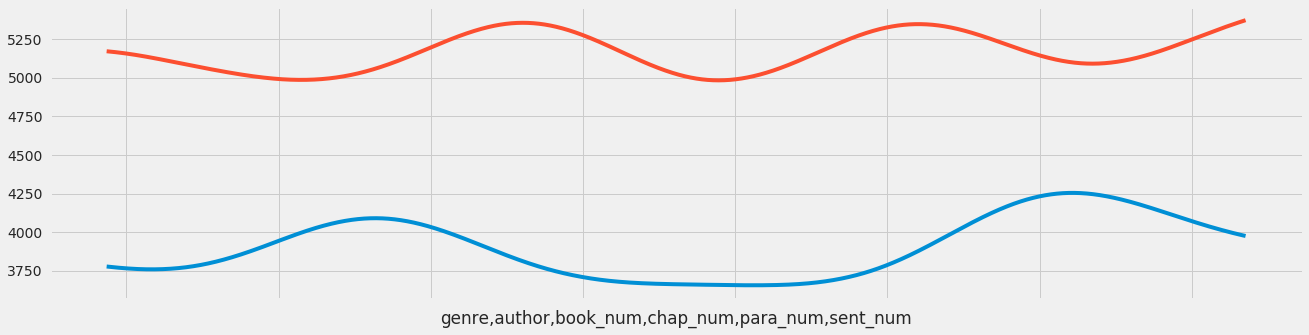

In [86]:
tokens[['bing_positive','bing_negative']].fillna(0).rolling(**CFG2).sum().plot(**FIG)

## Multinomial Emotions

In [87]:
EOM = tokens[emo_cols].reset_index(drop=True)

In [88]:
EOM.head()

,nrc_anger,nrc_anticipation,nrc_disgust,nrc_fear,nrc_joy,nrc_negative,nrc_positive,nrc_sadness,nrc_surprise,nrc_trust,bing_negative,bing_positive,bing_sentiment,syu_sentiment,gi_sentiment
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0


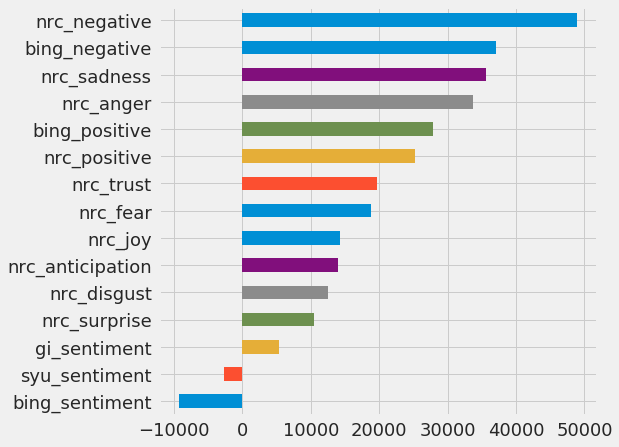

In [89]:
EOM.sum().sort_values().plot.barh(figsize=(7,7), fontsize=18)

### Shape data for Sklearn's KDE function

In [90]:
emo_offsets = []
for col in emo_cols:
    x = EOM[EOM[col] > 0].index.tolist()
    y = [[i] for i in x]
    emo_offsets.append((col, y))
B = pd.DataFrame(emo_offsets, columns=['emo', 'x'])
B = B.set_index('emo')

In [91]:
B

,x
emo,
nrc_anger,"[[153], [166], [337], [633], [970], [989], [99..."
nrc_anticipation,"[[16], [35], [43], [206], [258], [273], [304],..."
nrc_disgust,"[[3], [136], [255], [286], [337], [934], [1112..."
nrc_fear,"[[43], [153], [166], [304], [337], [633], [899..."
nrc_joy,"[[16], [114], [170], [206], [258], [273], [332..."
nrc_negative,"[[3], [136], [153], [255], [285], [337], [492]..."
nrc_positive,"[[16], [35], [57], [95], [114], [170], [206], ..."
nrc_sadness,"[[285], [286], [666], [899], [989], [1018], [1..."
nrc_surprise,"[[35], [43], [206], [258], [304], [374], [376]..."


### Get KDE for each emotion

In [92]:
scale_max = EOM.shape[0]
kde_bandwidth = 2500
# kde_bandwidth = 250
x_axis = np.linspace(0, scale_max, kde_samples)[:, np.newaxis]
B['kde'] = B.apply(lambda row: KDE(kernel=kde_kernel, bandwidth=kde_bandwidth).fit(row.x), 1)
B['scores'] = B.apply(lambda row: row.kde.score_samples(x_axis), axis=1)

### Visualize KDE plots

In [93]:
PLOTS = B.apply(lambda row: pd.Series(np.exp(row.scores) * (scale_max / kde_samples)), axis=1).T

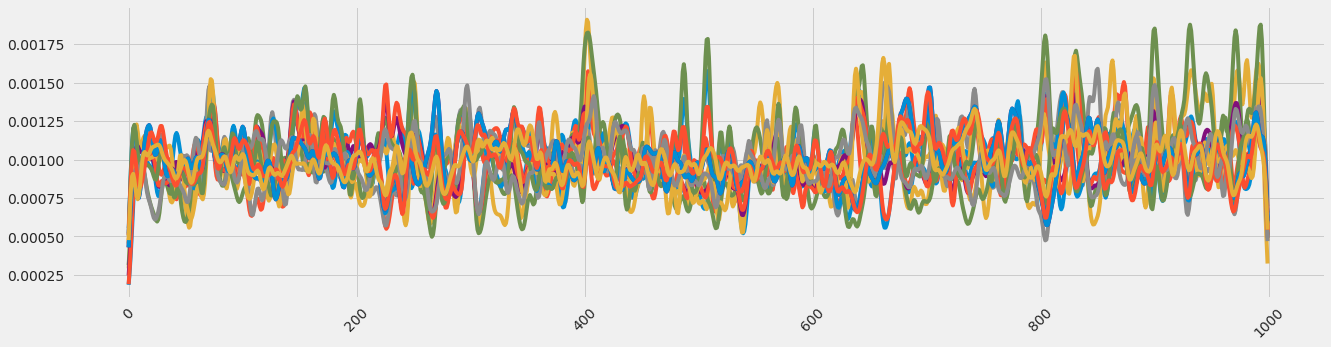

In [94]:
PLOTS.plot(**FIG)

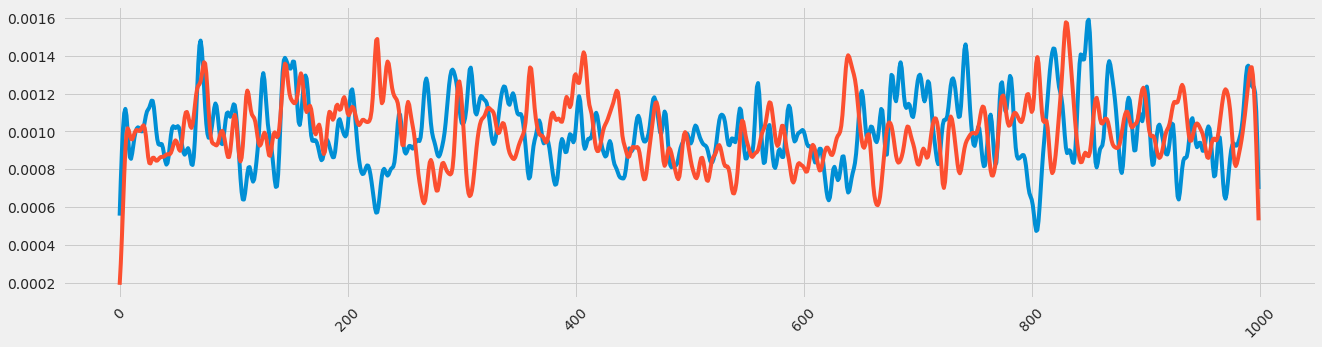

In [95]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

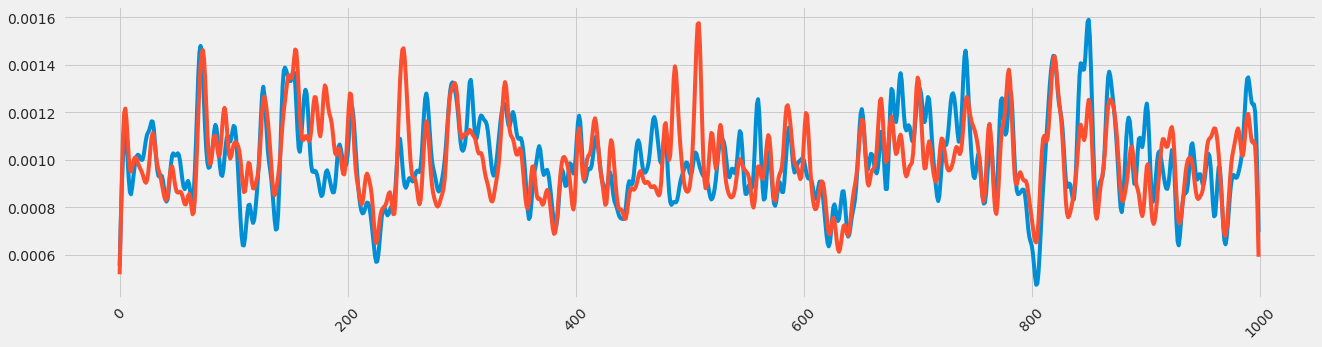

In [96]:
PLOTS[['nrc_joy','nrc_positive']].plot(**FIG)

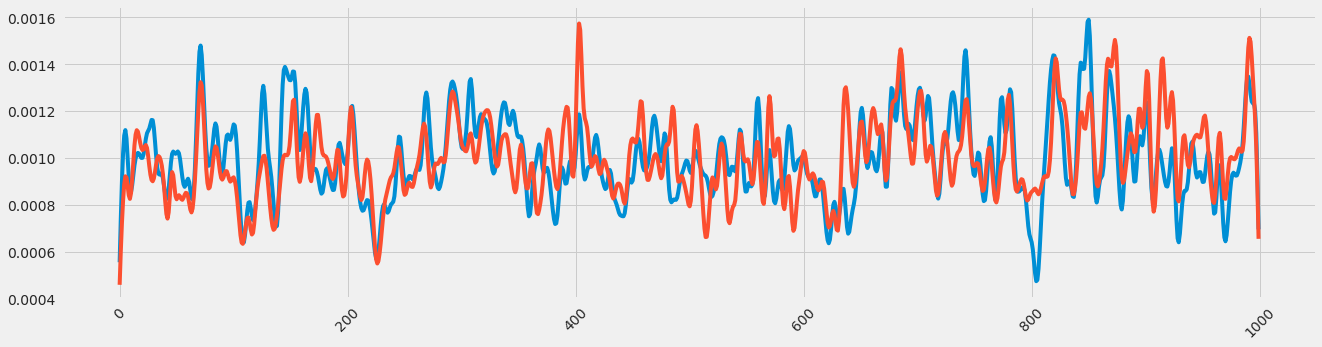

In [97]:
PLOTS[['nrc_joy','nrc_anticipation']].plot(**FIG)

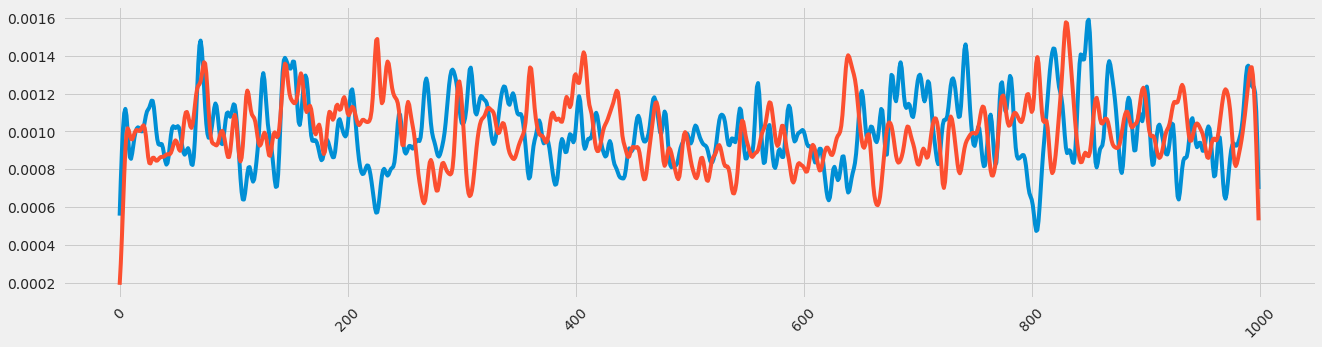

In [98]:
PLOTS[['nrc_joy','nrc_sadness']].plot(**FIG)

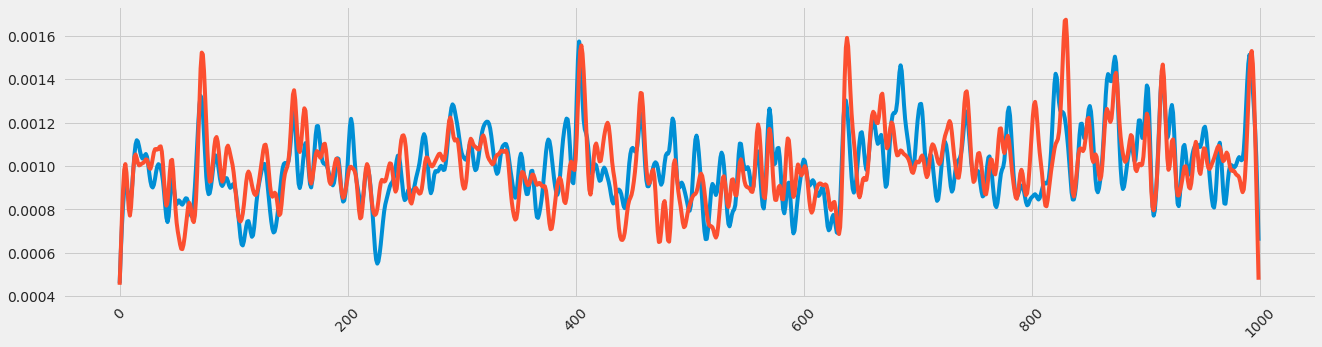

In [99]:
PLOTS[['nrc_anticipation','nrc_surprise']].plot(**FIG)

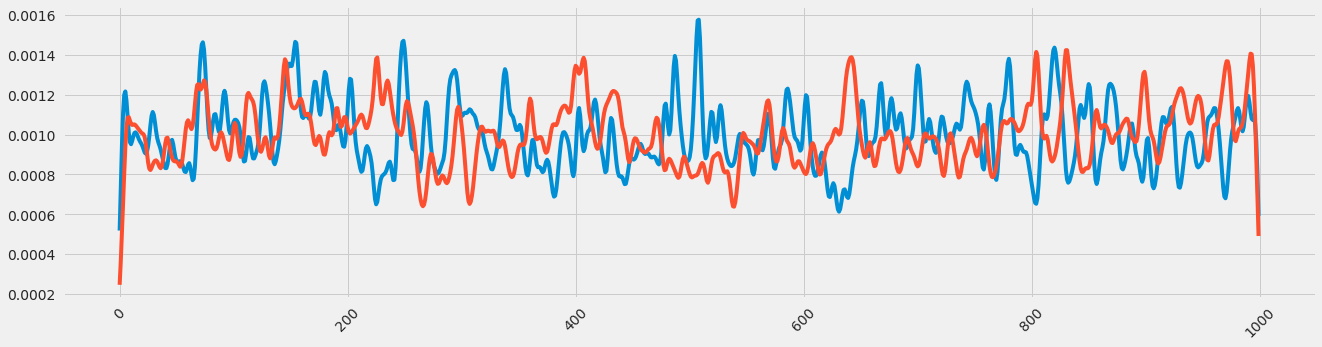

In [100]:
PLOTS[['nrc_positive','nrc_negative']].plot(**FIG)

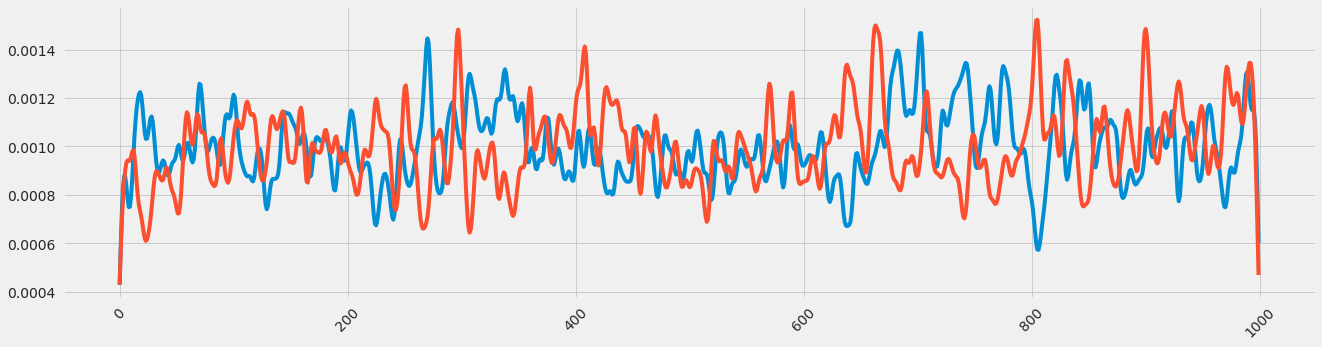

In [101]:
PLOTS[['bing_positive','bing_negative']].plot(**FIG)

### Compare KDE to Rolling graphs of Sentiment

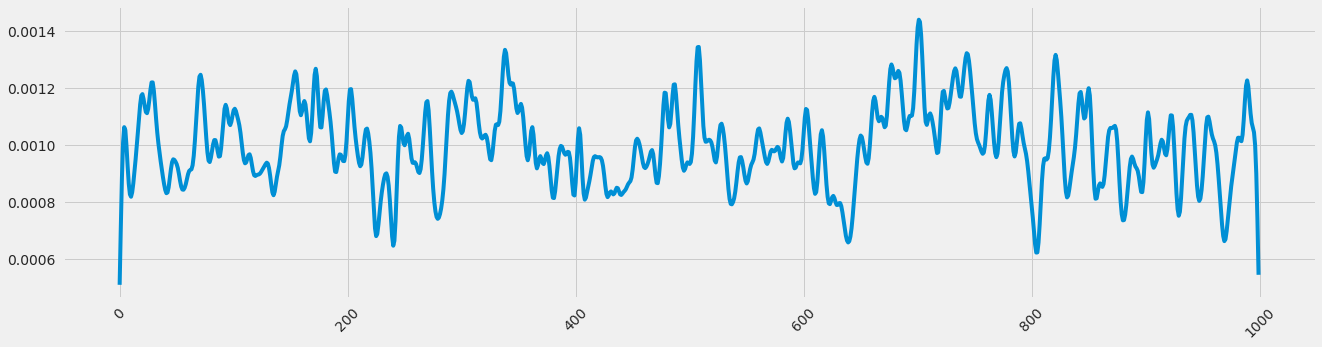

In [102]:
PLOTS[emo].plot(**FIG)

In [ ]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

In [ ]:
fig, axs = plt.subplots(len(emo_cols),2)
for i, emo in enumerate(emo_cols):
    FIGa = dict(figsize=(20,50), ax=axs[i,0], title=emo + ' (KDE)')
    FIGb = dict(figsize=(20,50), ax=axs[i,1], title=emo + ' (rolling)')
    PLOTS[emo].plot(**FIGa)
    tokens[emo].rolling(**CFG2).mean().plot(**FIGb)

## Peak Joy

### Find max joy from PLOTS

In [ ]:
PLOTS.head()

In [ ]:
PEAK_JOY = int((PLOTS['nrc_joy'].idxmax() / 1000) * tokens.shape[0])

In [ ]:
PEAK_JOY_CHAP_NUM = tokens.iloc[PEAK_JOY].name[0]

In [ ]:
PEAK_JOY_CHAP_NUM + 1

### Display Chapter

In [ ]:
PEAK_JOY_CHAP = tokens.loc[PEAK_JOY_CHAP_NUM].groupby(['para_num']).token_str.apply(lambda x: ' '.join(x)).tolist()

In [ ]:
display(HTML('<br/><br/>'.join(PEAK_JOY_CHAP)))

### Sparknotes' Synopsis

> One night, the Elliots receive an invitation to the Dalrymples' place, and Anne tells her family she must decline it because she has an engagement to visit Mrs. Smith. Sir Walter is horrified that Anne should be visiting such a poor neighborhood and is appalled that she chooses to associate with someone so much lower in consequence than herself.

https://www.sparknotes.com/lit/persuasion/section9/

## VADER

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

In [ ]:
vader_cols = by_sent.sent_str.apply(analyser.polarity_scores).apply(lambda x: pd.Series(x))

In [ ]:
by_sent = pd.concat([by_sent, vader_cols], axis=1)

In [ ]:
by_sent.head()

In [ ]:
# See "anne could not help laughing"
by_sent.sort_values('neg', ascending=False).head(10)

In [ ]:
CFG1['window'] = 500

In [ ]:
by_sent[['pos','neg']].rolling(**CFG1).sum().plot(**FIG)
by_sent[['compound']].rolling(**CFG1).sum().plot(**FIG)

## Compare KDE to Rolling Both Graphs of Syuzhet and VADER

In [ ]:
PLOTS[emo].plot(**FIG)

In [ ]:
tokens[emo].fillna(0).rolling(**CFG2).mean().plot(**FIG)

In [ ]:
by_sent[['compound']].rolling(**CFG1).mean().plot(**FIG)

In [ ]:
by_sent[emo].fillna(0).rolling(**CFG1).mean().plot(**FIG)

## Experimental Plotting Function

In [ ]:
def  plot_sentiment(emo_col, type='sent'):
    if type == 'sent':
        by_sent[emo_col].fillna(0).rolling(**CFG1).mean().plot(**FIG)
    elif type == 'tokens':
        tokens[emo_col].fillna(0).rolling(**CFG2).mean().plot(**FIG)
    elif type == 'kde':
        PLOTS[emo_col].plot(**FIG)
    else:
        pass

In [ ]:
plot_sentiment('gi_sentiment')
plot_sentiment('syu_sentiment')
plot_sentiment('bing_sentiment')

In [ ]:
plot_sentiment('gi_sentiment', type='tokens')
plot_sentiment('syu_sentiment', type='tokens')
plot_sentiment('bing_sentiment', type='tokens')

In [ ]:
plot_sentiment('gi_sentiment', type='kde')
plot_sentiment('syu_sentiment', type='kde')
plot_sentiment('bing_sentiment', type='kde')